In this tutorial, you will use `ParticleInCell` to model one of the simplest phenomena in
plasma physics: an electrostatic (or Langmuir) oscillation. This tutorial is part of a
series of examples that uses `ParticleInCell` to demonstrate the basic plasma physics
concepts that are covered in [Birdsall and Langdon's classic PIC textbook](@cite
birdsall2004).

A Langmuir oscillation occurs when a slab of charge in a uniform plasma is
displaced. The resulting charge density gradient creates a restoring force
that causes the displaced slab of charge to return to its original position.
But---just as in a classical pendulum oscillation---the momentum of the
charge carries it past its equilibrium point, creating an opposite charge
gradient, and a restoring force in the opposite direction. As a result, the
slab of charge oscillates around its equilibrium forever (at least in this
idealized model that ignores possible damping mechanisms).
For a plasma composed of a single mobile species $s$ with mass $m_s$ and charge
$q_s$, the frequency of this oscillation is given by
$$
\omega_{p,s} = \sqrt{\frac{n_s q_s^2}{\epsilon_0 m_s}}
$$
where $n_s$ is the number density of the plasma and $\epsilon_0$ is the permitivity of
free space. Notice that the plasma frequency has a $m_s^{-1/2}$ dependence, and thus the
lightest species (typically electrons) will dominate the dynamics of a plasma oscillation.
For this reason, we will only model the dynamics of the electrons in our simulation.

## Simulating a cold electron plasma
We begin by loading the `ParticleInCell` package. Additionally, we load `CairoMakie`
which is a backend for [`Makie`](https://makie.org) that can generate beautiful,
publication-quality graphics.

In [1]:
using ParticleInCell
using CairoMakie
CairoMakie.activate!(type = "svg") #hide
docs_theme = Theme(
    fontsize = 20,
    fonts = (; regular = "Lato", bold = "Lato Bold"),
    palette = (color = [:black, :red, :blue],),
    Axis = (xgridvisible = false, ygridvisible = false),
    Scatter = (; cycle = [:color]),
    Lines = (; cycle = [:color]),
)
set_theme!(docs_theme) #hide

We begin by creating some electrons to move in the simulation. For even a tiny simulation
volume, there are *far* too many physical electrons to simulate each one individually.
Instead, PIC algorithms group physical particles into 'macroparticles'. The distribution
of macroparticles in phase space serves as an approximation for the phase space
distribution of physical particles. We arbitrarily choose a simulation domain of length
one, and a nominal electrons number density of $10^{14}$. Then, for a given number of
macroparticles, we can calculate the number of physical electrons represented by each.

In [2]:
sim_length = 1.0
number_density = 1e14
num_macroparticles = 320
particles_per_macro = number_density * sim_length / num_macroparticles

3.125e11

We distribute the macroparticles evenly across the simulation domain.

In [3]:
positions = collect(0:num_macroparticles-1) ./ num_macroparticles;

In order to seed a Langmuir oscillation, we give the electrons a sinusoidal velocity
perturbation. This corresponds to the moment in a Langmuir oscillation when the slab of
charge has reached equilibrium, but is being carried past by its momentum. This
perturbation is defined by a wavenumber `k` and an `amplitude`.

In [4]:
k = 1 * 2pi / sim_length
amplitude = 1e3
elec_mass = 9e-31
momentums = (particles_per_macro * elec_mass * amplitude) .* sin.(positions .* k);

We can visualize the initial condition of the electron macroparticle by plotting the
initial phase space.

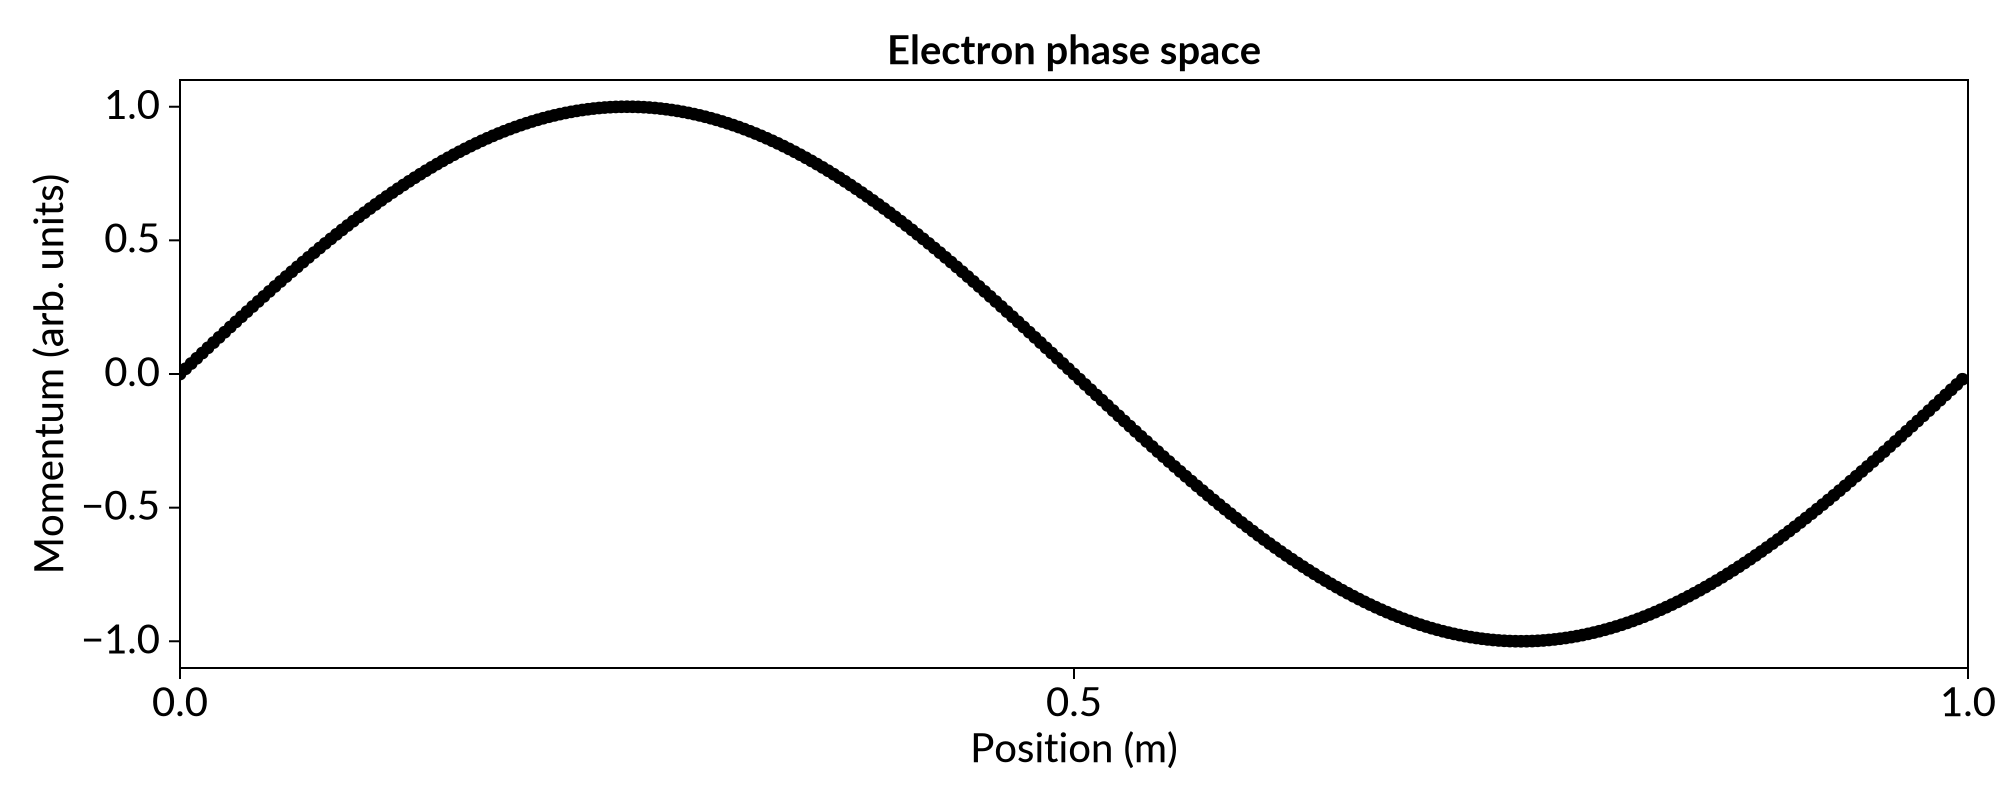

In [5]:
fig = Figure(size = (1000, 400))
ax = Axis(
    fig[1, 1],
    title = "Electron phase space",
    xlabel = "Position (m)",
    ylabel = "Momentum (arb. units)",
    limits = ((0, 1), nothing),
)
scatter!(ax, positions, momentums ./ maximum(momentums))
fig

Finally, we create a `VariableWeightSpecies` which holds the all of the
macroparticles. Additionally, we must pass the value of
`particles_per_macro`, which is used to calculate the charge and mass of the
macroparticles.

In [6]:
electrons = ParticleInCell.electrons(positions, momentums, particles_per_macro);

Now we address the 'cell' piece of particle-in-cell by creating a `grid`. Because Langmuir
oscillations are a one-dimensional phenomena, we will choose to perform a 1D simulation.

The choice of grid resolution is determined by the scale of the smallest relevant dynamics
begin simulated. For a Langmuir oscillation, the scale of the dynamics is set by `k`, and
so the simulation could likely accomplished with as few as 4 or 8 cells. However, this is
not a computationally demanding simulation, and so we arbitrarily choose to use 32 equally
spaced (i.e. uniform) grid points. Additionally, we make the simulation domain periodic.

In [7]:
num_cells = 32
dx = sim_length / num_cells
periodic = true
grid = UniformCartesianGrid((0.0,), (sim_length,), (num_cells,), (periodic,));

At this point, we must choose a timestep for the simulation. We would like to use a large
timestep so that more of the systems dynamics can be observed with the same number of
steps. However, we must resolve the fastest timescale of the dynamics that we are trying
to simulate. In this case, we must resolve the plasma frequency. Additionally, we must
choose a timestep that is short enough that particles do not cross more than one cell per
timestep to prevent numerical instabilities from arising. For the oscillation amplitude
that we have chosen, the particles do not move fast enough for the CFL condition to
matter, and so we will choose our timestep based on the expected plasma frequency.

In [8]:
epsilon_0 = 8.8e-12
elec_charge = 1.6e-19
elec_mass = 9e-31
expected_plasma_freq = sqrt(number_density * elec_charge^2 / elec_mass / epsilon_0)
expected_plasma_period = 2pi / expected_plasma_freq

1.1051531770007306e-8

In order for the simulation to be accurate, there must be several timesteps per
plasma period (or equivalently, several timesteps per inverse plasma frequency).
For now, we will arbitrarily choose to have 100 timesteps per plasma period, and
later, we will explore how changing the time step effects the accuracy of the
simulation.

In [9]:
dt = 0.01 / expected_plasma_freq

1.7589059099337862e-11

Now we need to set up the fields required for the electrostatic PIC simulation,
as well as specify the exact steps that will occur during each step..
To do this, we will use a helper function to create the fields and steps.

In [10]:
sim, fields = create_electrostatic_simulation(grid, [electrons], dt);

The variable `sim` holds the steps, and `fields` is a named tuple of the rho,
phi, and electric fields (actually two electric fields, one at the edge of each grid
cell, and one at the nodes). In this tutorial, we won't go over the details of the
PIC method, but you can find more details in the theory section of the manual.
However, we will need the nodal electric field later in the tutorial, so we assign
that field to its own variable.

In [11]:
Enode = fields[:Enode];

Now we are ready to run the simulation. We will simulate the plasma for 1000
timesteps, and at each step, we will calculate the electric field energy,
$$
U_E = \int |E(x)|^2 \,\mathrm{d}x.
$$
This field energy will oscillate as the electrons move in and out of
equilibrium, and so we can use it to observe the Langmuir oscillation.

In [12]:
n_steps = 10000

electric_field_energy = Vector{Float64}(undef, n_steps)

for n = 1:n_steps
    # Calculate the electric field energy
    electric_field_energy[n] = 0
    for I in eachindex(Enode)
        electric_field_energy[n] += (dx * epsilon_0 / 2) * (Enode.values[I])^2
    end

    step!(sim)
end

We can now visualize the electric field energy to see the plasma oscillation.

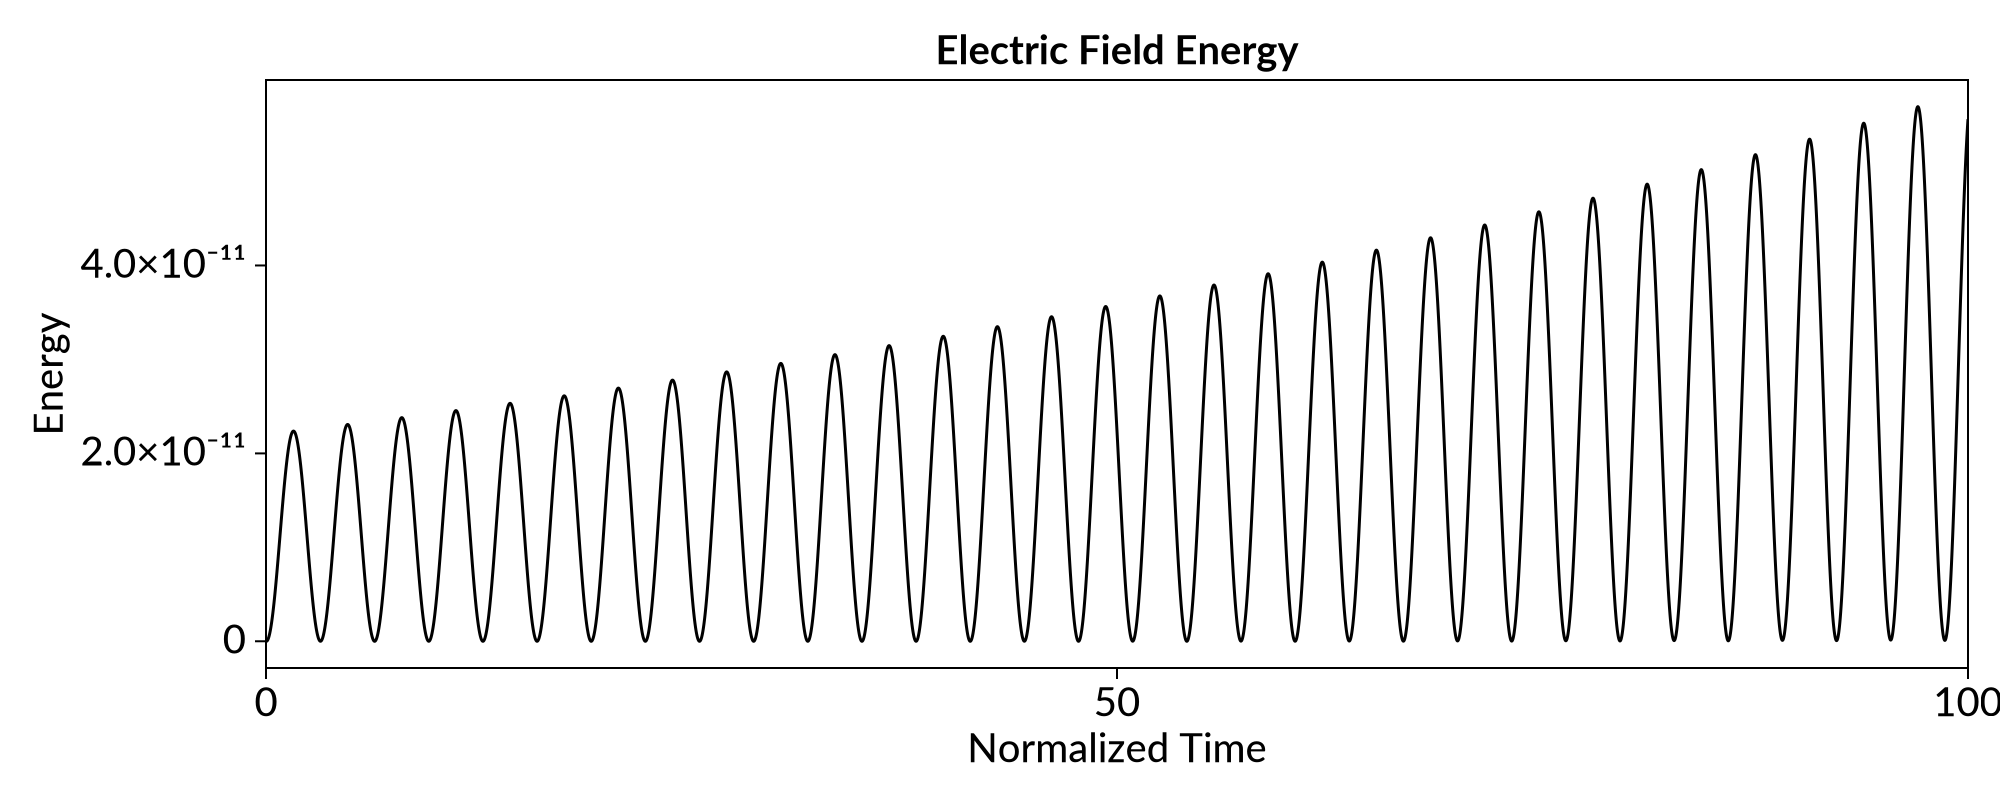

In [13]:
normalized_times = collect(range(1, n_steps)) .* dt .* expected_plasma_freq
fig = Figure(size = (1000, 400))
ax = Axis(
    fig[1, 1],
    title = "Electric Field Energy",
    xlabel = "Normalized Time",
    ylabel = "Energy",
    limits = ((0, 100), nothing),
)
lines!(normalized_times, electric_field_energy)
fig

Notice that the electric field energy is slowly growing over time, which is
unphysical. We will discuss where this numerical instability comes from--
and how it can be avoided--later. But for now, we can still use the
electric-field-energy time series to calculate the plasma frequency. First,
let's plot the Fourier transform of the electric field energy.

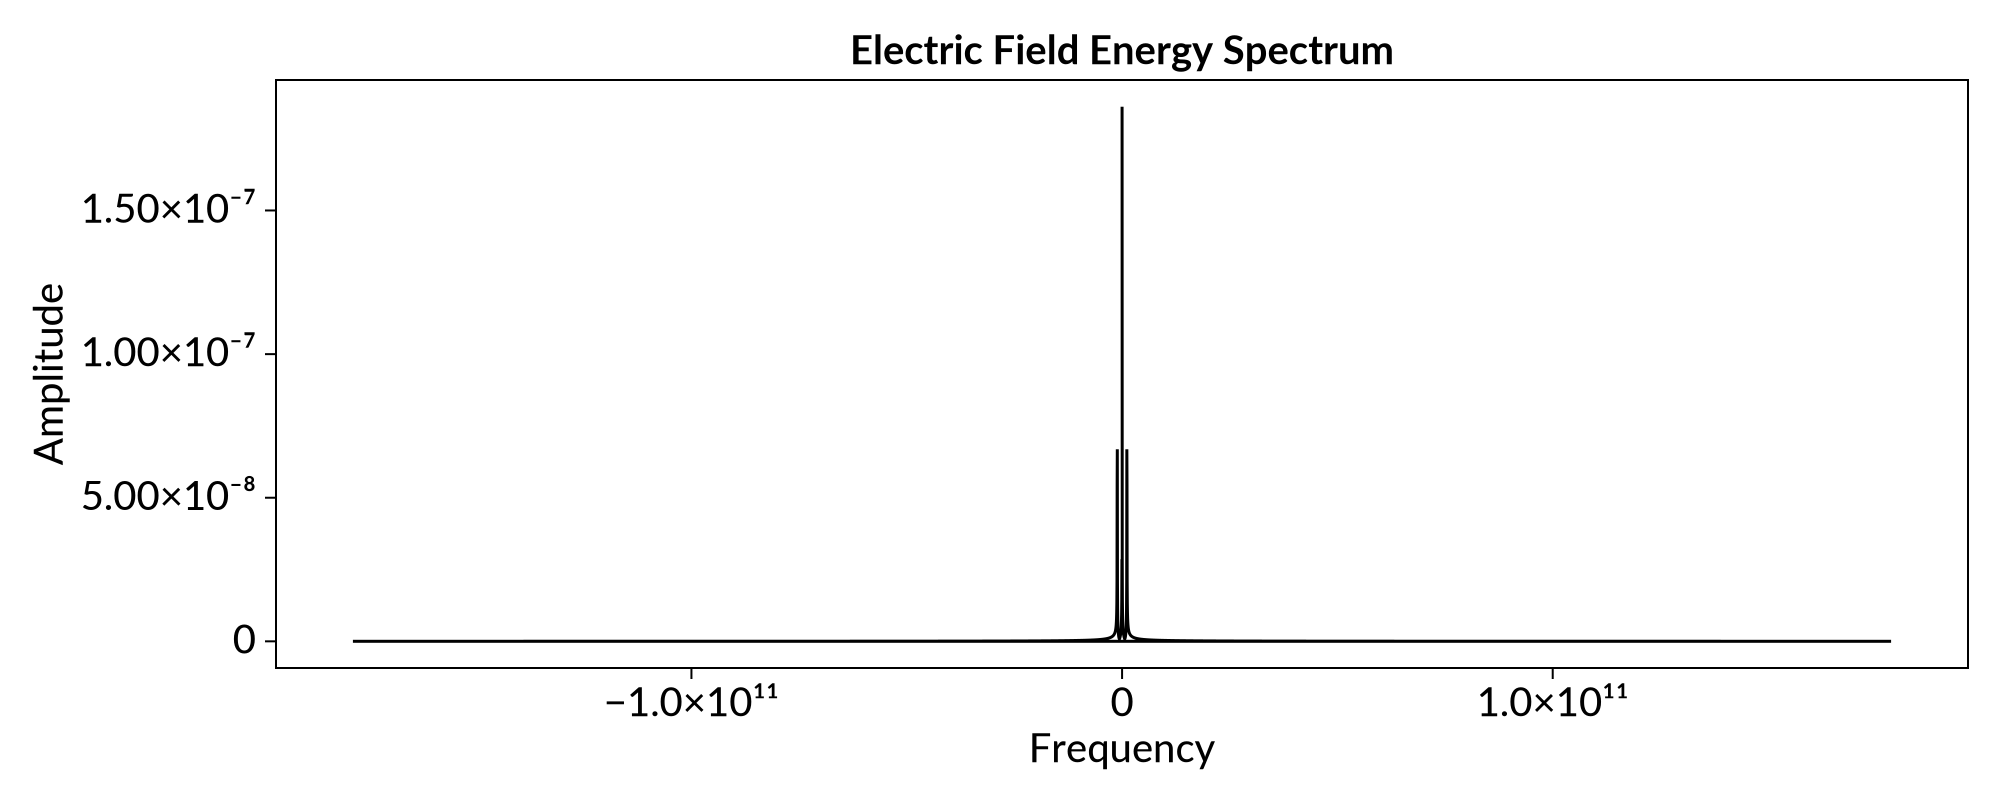

In [14]:
using FFTW

freqs = fftfreq(n_steps, 1 / dt) .* 2pi
freq_amps = abs.(fft(electric_field_energy))

fig = Figure(size = (1000, 400))
ax = Axis(
    fig[1, 1],
    title = "Electric Field Energy Spectrum",
    xlabel = "Frequency",
    ylabel = "Amplitude",
)
lines!(ax, freqs, freq_amps)
fig

It is hard to see what is happening at the low frequencies, so let's zoom
in on the positive low frequencies.

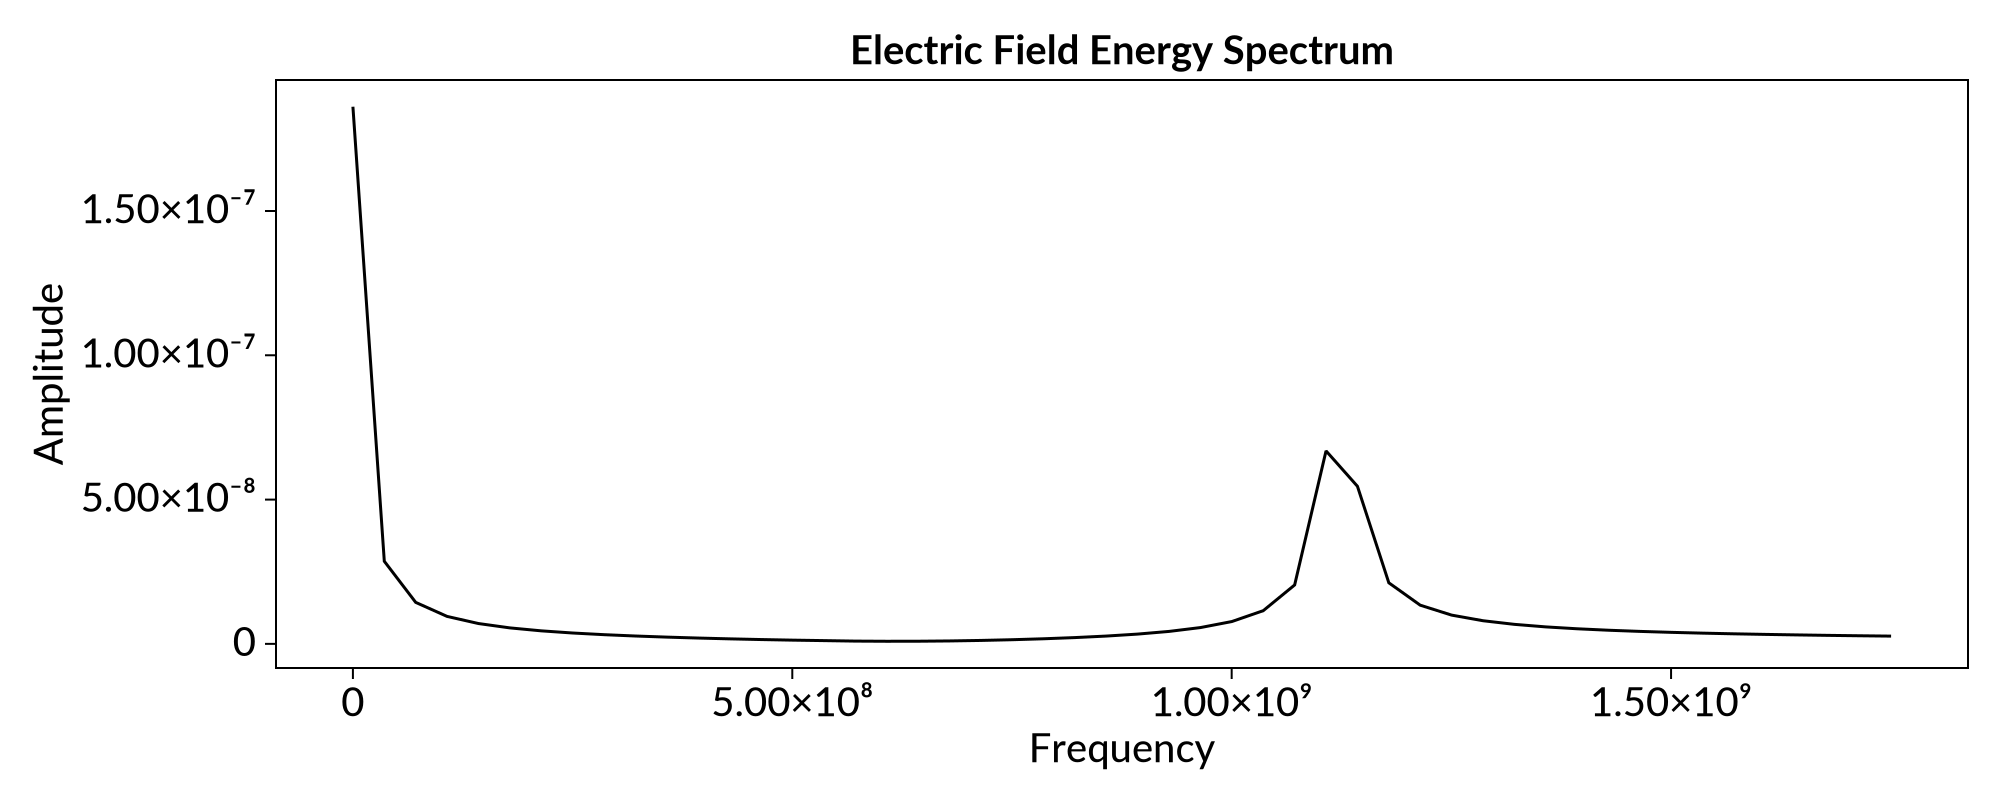

In [15]:
cutoff_index = round(Int, n_steps * 0.005)
fig = Figure(size = (1000, 400))
ax = Axis(
    fig[1, 1],
    title = "Electric Field Energy Spectrum",
    xlabel = "Frequency",
    ylabel = "Amplitude",
)
lines!(ax, freqs[1:cutoff_index], freq_amps[1:cutoff_index])
fig

Next, we find the maximum frequency. We don't care about the spike at zero frequency (that
is just a consequence of the electric field energy being a strictly positive quantity) so
we will zero out all of the frequencies below $5 \times 10^8$ Hz. We then
find the largest remaining amplitude, and it's corresponding frequency.

In [16]:
freq_amps .= ifelse.(freqs .< 5e8, 0, freq_amps)
max_index = findmax(freq_amps)[2]
max_freq = freqs[max_index]

# Divide by 2 because the electric field energy goes through a maximum twice
# per plasma oscillation, and take the absolute value because we don't care
# about the phase of the oscillation.
measured_plasma_freq = abs(max_freq / 2)

5.5369290484077e8

One last plot, showing the zeroed out low frequencies, and the measured
oscillation frequency:

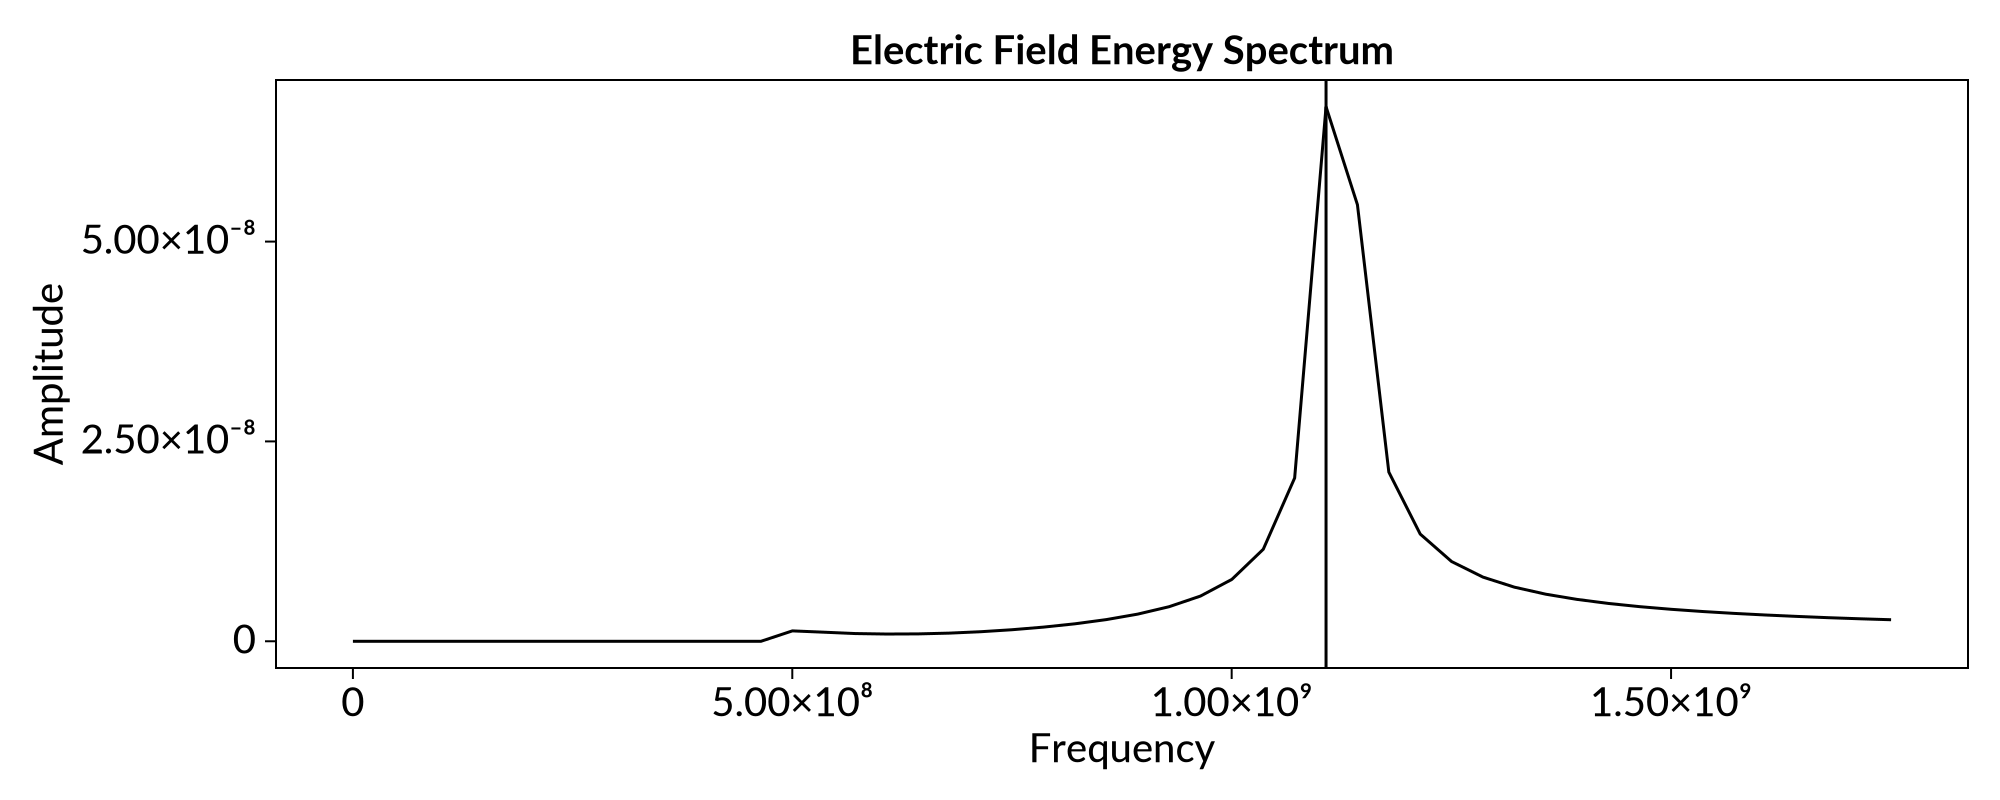

In [17]:
fig = Figure(size = (1000, 400))
ax = Axis(
    fig[1, 1],
    title = "Electric Field Energy Spectrum",
    xlabel = "Frequency",
    ylabel = "Amplitude",
)
lines!(ax, freqs[1:cutoff_index], freq_amps[1:cutoff_index])
vlines!(ax, [measured_plasma_freq * 2])
fig

Finally, we can compare this to the theoretically expected result:

In [18]:
relative_error = (measured_plasma_freq - expected_plasma_freq) / expected_plasma_freq

-0.026106277387164183

Less than a 5% error.

## Scaling of frequency error with wavenumber
In the previous section, we seeded a plasma oscillation that spanned the entire
simulation domain. That is, the wavenumber was
$$
k_\text{min} = \frac{2 \pi}{\lambda} = \frac{2 \pi}{L}.
$$
This is the best possible case, because the oscillation spans as many grid cells
as possible. However, as the wavenumber increases (and equivalently, the wavelength
decreases), the finite grid effects will start to become more important, and they
will result in an increased error in the measured plasma frequency.

Our goal in this section will be to observe and quantify this finite grid error.
We begin by defining a function that will run a PIC simulation at a specified
wavenumber, and return the measured plasma frequency.

In [19]:
function measure_plasma_frequency(number_density, wavenumber, normalized_timestep = 0.01)
    sim_length = 1.0
    num_cells = 32
    dx = sim_length / num_cells

    num_macroparticles = 10 * num_cells
    particles_per_macro = number_density * sim_length / num_macroparticles

    perturb_amplitude = 1e3
    elec_mass = 9e-31
    positions = collect(0:num_macroparticles-1) ./ num_macroparticles
    momentums =
        (particles_per_macro * elec_mass * perturb_amplitude) .*
        sin.(positions .* wavenumber)

    electrons = ParticleInCell.electrons(positions, momentums, particles_per_macro)

    grid = UniformCartesianGrid((0.0,), (sim_length,), (num_cells,), (true,))

    epsilon_0 = 8.8e-12
    elec_charge = 1.6e-19
    expected_plasma_freq = sqrt(number_density * elec_charge^2 / elec_mass / epsilon_0)
    dt = normalized_timestep / expected_plasma_freq
    sim, fields = create_electrostatic_simulation(grid, [electrons], dt)
    Enode = fields[:Enode]

    # We want to simulate the same length of physical time for each simulation,
    # so we need to have more steps when the timestep is shorter.
    n_steps = round(Int, 100 / normalized_timestep)
    electric_field_energy = Vector{Float64}(undef, n_steps)

    epsilon_0 = 8.8e-12
    for n = 1:n_steps
        # Calculate the electric field energy
        electric_field_energy[n] = 0
        for I in eachindex(Enode)
            electric_field_energy[n] += (dx * epsilon_0 / 2) * (Enode.values[I])^2
        end

        step!(sim)
    end

    freqs = fftfreq(n_steps, 1 / dt) .* 2pi
    freq_amps = abs.(fft(electric_field_energy))

    freq_amps[1] = 0
    max_index = findmax(freq_amps)[2]
    max_freq = freqs[max_index]
    plasma_freq = abs(max_freq / 2)

    return plasma_freq
end;

Let's run several simulations with different timesteps, and compare the accuracy
of each simulation.

In [20]:
wavenumbers = 2 * pi .* [2, 4, 8, 16]
plasma_freqs = measure_plasma_frequency.(1e14, wavenumbers, 0.001)

4-element Vector{Float64}:
 5.536929048407701e8
 5.179707819478172e8
 3.9294335182248205e8
 1.7861061446476456e7

Let's plot the wavenumber of the oscillation verses the relative error between the
observed and predicted plasma frequencies. We expect that the error will be some
power law relation to the wavenumber, and so we will use a log-log plot.

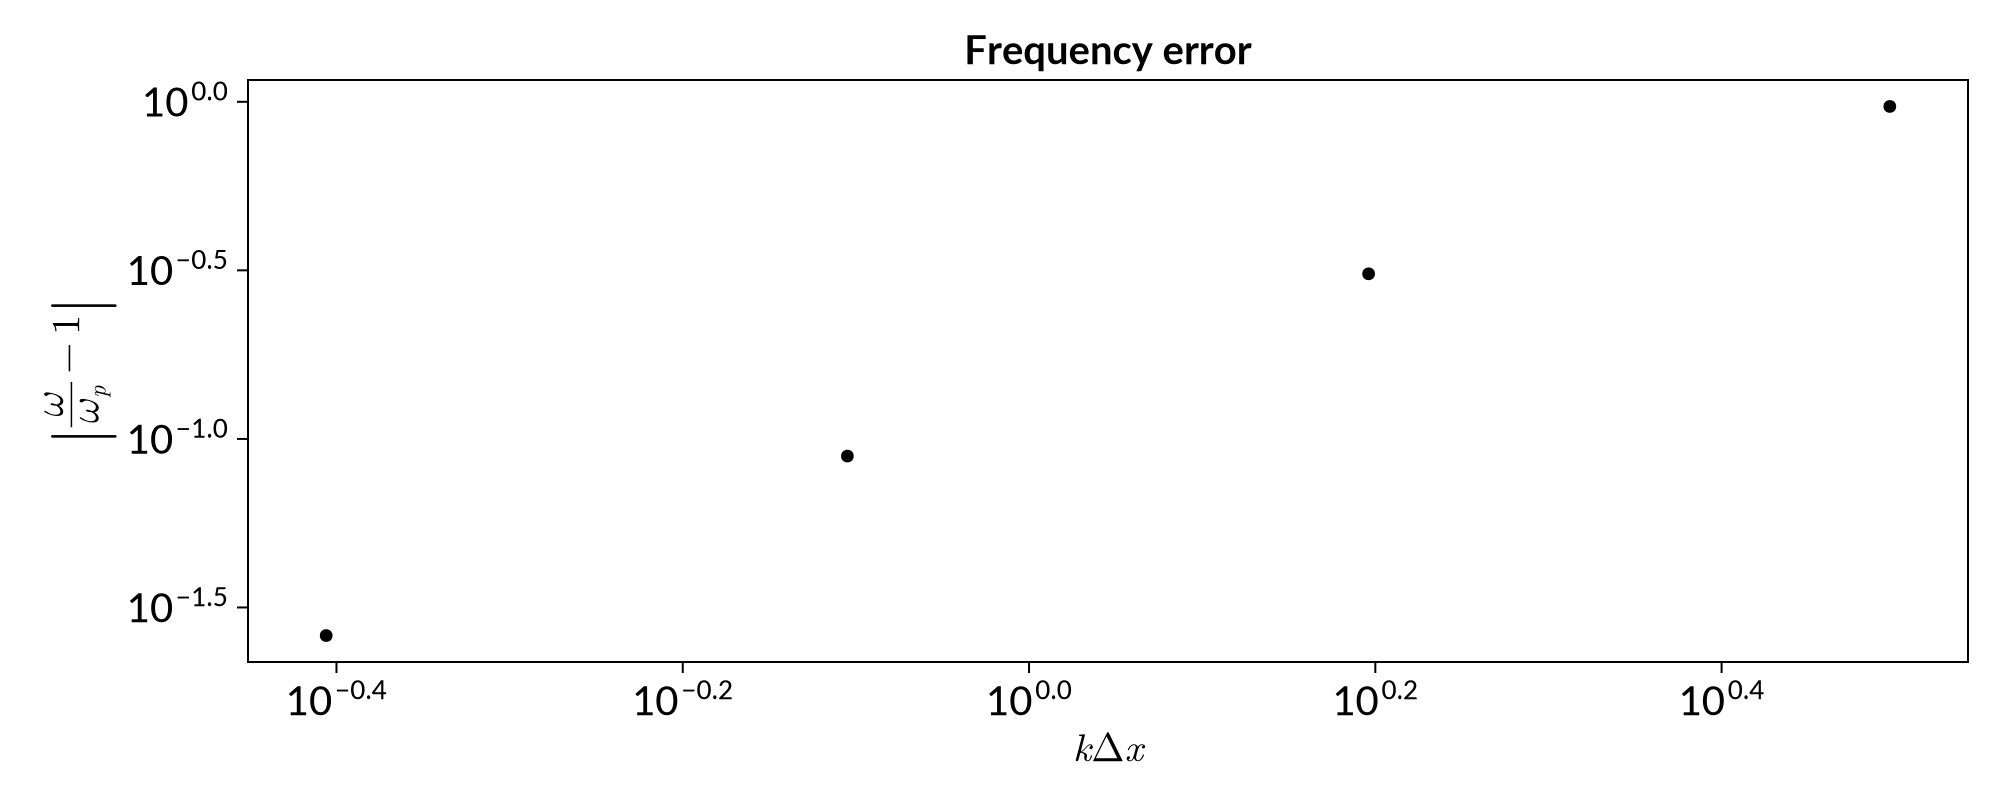

In [21]:
dx = 1 / 32
normalized_wavenumbers = wavenumbers .* dx
relative_errors = abs.(plasma_freqs ./ expected_plasma_freq .- 1)

fig = Figure(size = (1000, 400))
ax = Axis(
    fig[1, 1],
    title = "Frequency error",
    xlabel = L"k \Delta x",
    ylabel = L"\left|\frac{\omega}{\omega_p} - 1\right|",
    xscale = log10,
    yscale = log10,
)
scatter!(ax, normalized_wavenumbers, relative_errors)
fig

Indeed, the error does appear to have a power law relation with the normalized
wavenumber. Let's fit the data to determine the index of the power law. We will
use the `LsqFit` package, which provides utilities for fitting data. We have
observed that the data is linear when plotted on a log-log plot, and so we will
fit the log-transformed data using a linear model.

In [22]:
using LsqFit

model(x, p) = p[1] .+ x .* p[2]
fit = curve_fit(model, log10.(normalized_wavenumbers), log10.(relative_errors), [0.0, 2.0])
params = coef(fit)

2-element Vector{Float64}:
 -0.8690885032869285
  1.743625642496926

Notice that the second parameter, which corresponds to the exponent in the power law,
is about two. This makes sense, because the PIC algorithm we are using has second order
accuracy in $k \Delta x$. As a final sanity check, let's plot the fit.

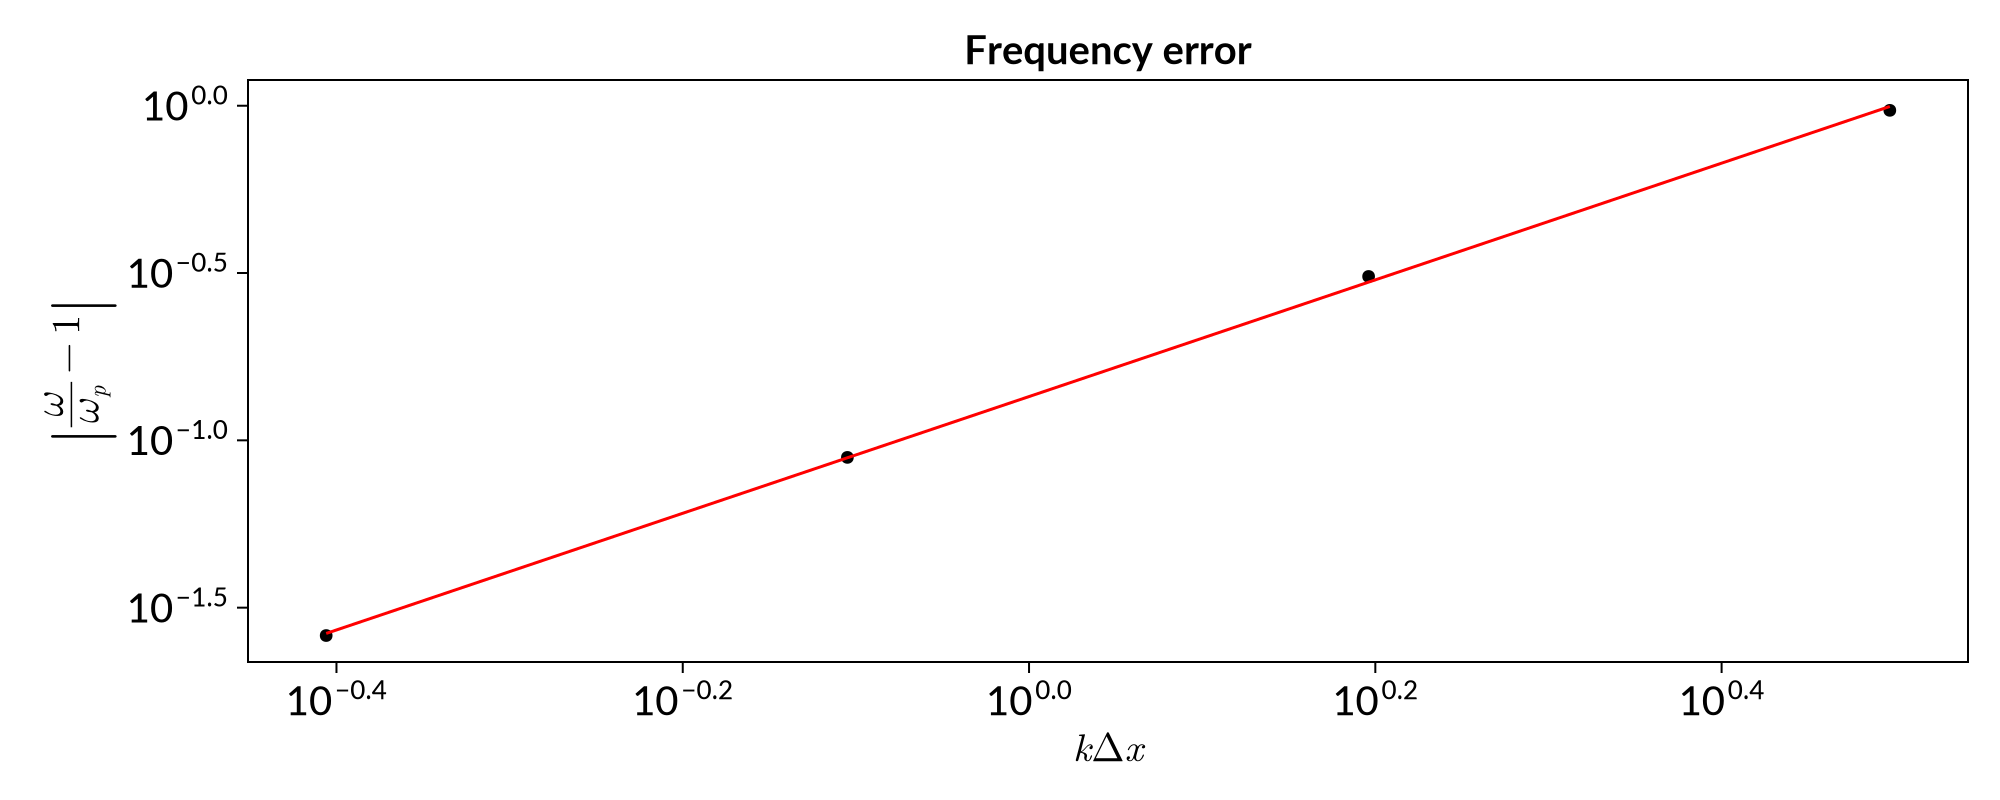

In [23]:
lines!(
    ax,
    normalized_wavenumbers,
    (10^params[1]) .* normalized_wavenumbers .^ params[2],
    color = :red,
)
fig

There is one last thing we can do with this error model: we can us it to correct
out simulation results! Our model gives us the relation
$$
\left|\frac{\omega}{\omega_p} - 1\right| = C (k \Delta x)^p.
$$
We can solve for $\omega_p$, to obtain
$$
\omega_p = \frac{\omega}{1 \pm C (k \Delta x)^p}.
$$
Let's find the error in the corrected plasma frequencies.

In [24]:
corrected_plasma_freqs =
    plasma_freqs ./ (1 .- (10^params[1]) .* normalized_wavenumbers .^ params[2])
corrected_relative_errors =
    (corrected_plasma_freqs .- expected_plasma_freq) ./ expected_plasma_freq

4-element Vector{Float64}:
  0.0003955396156326958
 -0.00024698896102469636
 -0.01674606541861653
  5.092479974228979

Of course, this example is somewhat unrealistic: if we already know what the
plasma frequency should be, why are we running simulations to measure it?!?!
However, this general technique remains valid, even when we don't know what
the correct answer is a priori. This is why it is so important to conduct
scaling studies to gain confidence that your simulation is actually resolving
the physics that you think it is.

## Wrap up
In this tutorial, you have learned how to simulate an electrostatic Langmuir
oscillation using `ParticleInCell`. Additionally, you have verified error scaling
of the algorithm in $k \Delta x$, and used this information to correct the
originally measured plasma frequency.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*